In [2]:
# Dependencies Import Setup 
#---------------------------
import pandas as pd  
# Pandas is used for data manipulation and analysis, such as reading and working with CSV files.
from pathlib import Path
# The path class provides as easy and platform-independent way to work with file system paths.
import numpy as np
# NumPy is used for numerical operations and working with arrays, which is often helpful in data analysis.
import matplotlib.pyplot as plt
# Pyplot is used to create visualizations like plots and charts.
import requests
# The requests library is used to make HTTP requests, which can be useful for fetching data from web APIs.
import os
# The os module provides a way to interact with the operations system, such as reading enviroment variables or working with file paths

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

%matplotlib inline
# This is a jupyter notebook magic command
# It tells the notebook to display Matplotlib plots directly within the notebook cells (inline) rather than in a seprarte window.

# CSV Import

#Import API Key

In [3]:
# 1. Data Cleaning & Preperation
# ------------------------------

file_path = Path("data/detailed_ev_charging_stations.csv")
# Creates a Path object that points to the CSV file.
# Using a Path object helps manage file paths in a way that's indepentent of the operating system.
# Be cautious with backslashes (\) as they can be interpreted as escape characters. You might consider using raw strings (e.g., r"\Repos\ev-charging-stations\data\
# detailed_ev_charging_station.csv") or forward slashes (/).

detailed_ev_charging_station = pd.read_csv(file_path)
# Reads the csv file located at file_path into a Pandas DataFrame called detailed_ev_charging_station.
# This allows you to work with the data (e.g., inspect, manipluate, analyze) using the tools provided by Pandas.

detailed_ev_charging_station.rename(columns={ 
    'Installation Year': 'Installation Year',
    'Charging Capacity (kW)': 'Charging Capacity (kW)',
    '24/7 Availability': 'Is_24_7',
    'Usage Stats (avg users/day)': 'Usage (avg users/day)'
}, inplace=True)
# detailed_ev_charging_station.rename(columns={...}, inplace=True): This line renames the columns of the DataFrame.
# inplace=True: This argument modifes the origianl DataFrame directly rather than creating a new DataFrame with renamed columns.

initial_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame to the variable initial_counts.
    # .shape[0]: The shape attribute returns a truple representing the demensionality of the DataFrame. The first element (index 0) of the truple represents 
    # the nuber of rows.
detailed_ev_charging_station.drop_duplicates(inplace=True)
# This line drops the duplicate rows from the DataFrame.
    # drop_duplicates(): This method removes duplicate rows from the DataFrame.
    # inplace=True: This argumnet modifes the origianl DataFrame directly rather than creating a new DataFrame without duplicates.
final_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame after dropping duplicates to the variable final_count.


print(detailed_ev_charging_station.head())
# Prints the first 5 rows ot the DataFrame
# The .head() method is a quick way to inspect the top of the DataFrame, which helps confirm that the data was read correctly and gives you a glimps of its structure. 

print(f"\nDropped {initial_count - final_count} duplicate rows.")
# This line prints the number of duplicate rows that are dropped.
    # This is an f-string, which allows for the inculsion of expressions inside curly braces{}. The expression initial_count - final_count calculates the 
    # number of duplicate rows dropped. The \n at the beginng of the strin adds a newline character for formatting purpose.
print("\n===Missing Values by Column ===")
print(detailed_ev_charging_station.isnull().sum())

detailed_ev_charging_station.dropna(subset=['Installation Year', 'Charging Capacity (kW)', 'Usage (avg users/day)'], inplace=True)
# This line drops rows in the DataFrame that have missing values in the specified columns.
# subset=: Specifies the columns to check for missing values.
# inplace=True: Modifes the origianl DataFrame directly rather than creating a new DataFrame without the rows containing missing values.

if 'Cost' in detailed_ev_charging_station.columns:
    # Checks if the 'Cost' column exsits in the DataFrame.
    detailed_ev_charging_station['Cost'].fillna(detailed_ev_charging_station['Cost'].median(), inplace=True)
    # This line fills missing values in the 'Cost' column with the median value of that column.
    # fillna: Uses the median value of the 'Cost' column to fill the missing values and modifies the DataFrame in place.

if 'City' in detailed_ev_charging_station.columns:
    # This line fills missing values of the 'City' column with the mode (most frequent value) of that column.
    detailed_ev_charging_station['City'].fillna(detailed_ev_charging_station['City'].mode()[0], inplace=True)
    # fillna: Uses the mode value of the 'City' column to fill the missing values and modifies the DataFrame in place.

detailed_ev_charging_station['Charging Capacity (kW)'] = pd.to_numeric(detailed_ev_charging_station['Charging Capacity (kW)'], errors= 'coerce')
# This line converts 'Charging Capacity (kW)' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

detailed_ev_charging_station['Usage (avg users/day)'] = pd.to_numeric(detailed_ev_charging_station['Usage (avg users/day)'], errors= 'coerce')
# This line converts 'Usage' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

numeric_cols = detailed_ev_charging_station.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    # Thsi line selects all columns in the DataFrame that are of numeric type.
    # select-dtypes: Selects the numeric data types.
    # .columns: Returns the column names of the selected numeric columns.

    mean_val = detailed_ev_charging_station[col].mean()
    # Claculates the mean value of the current column.
    std_val = detailed_ev_charging_station[col].std()
    # Calculates the standard devation of the current column.
    cutoff = 3 * std_val
    # Defines the cutoff value for the outliers as three times the standard devation.
    lower, upper = mean_val - cutoff, mean_val + cutoff
    # Defines the lower and upper bonds for acceptable values (mean ± 3*std).
    detailed_ev_charging_station = detailed_ev_charging_station[(detailed_ev_charging_station[col] >= lower) & (detailed_ev_charging_station[col]<= upper)]
    # filters the DataFrame to keep only the rows where the values in the current column are within the acceptable range (between the upper and lower bonds).

print("n\=== Cleaned DataFrame Info ===")
# Prints a heading the the DataFrame information output.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.info()
# Prints a summary of the Dataframe, including the number of rows, columns, and data types of each column.
print("\n=== first 5 Rows After Cleaning")
# Prints a heading for the first 5 rows of the DataFrame.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.head()
# Prints the first 5 rows of the cleaned Dataframe.


  Station ID   Latitude   Longitude                                Address  \
0   EVS00001 -33.400998   77.974972       4826 Random Rd, City 98, Country   
1   EVS00002  37.861857 -122.490299  8970 San Francisco Ave, San Francisco   
2   EVS00003  13.776092  100.412776              5974 Bangkok Ave, Bangkok   
3   EVS00004  43.628250  -79.468935              6995 Toronto Ave, Toronto   
4   EVS00005  19.119865   72.913368                5704 Mumbai Ave, Mumbai   

      Charger Type  Cost (USD/kWh) Availability  Distance to City (km)  \
0       AC Level 2            0.27   9:00-18:00                   4.95   
1  DC Fast Charger            0.19         24/7                   4.96   
2       AC Level 2            0.48   6:00-22:00                   8.54   
3       AC Level 1            0.41   9:00-18:00                  13.28   
4       AC Level 2            0.11   9:00-18:00                   9.76   

   Usage (avg users/day) Station Operator  Charging Capacity (kW)  \
0                

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually


In [4]:
# Get the city from the latitude and longitude
# Empty lists for holding the city names
cities = []
# Empty list for holding the latitude and longitude combinations
lat_lngs = []
lats = detailed_ev_charging_station['Latitude']
lngs = detailed_ev_charging_station['Longitude']
lat_lngs = zip(lats, lngs)
# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    # add it to a our cities list
    cities.append(city)
# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 4964


In [5]:
# Add cities to the data frame
detailed_ev_charging_station['City'] = cities + [np.nan] * (len(detailed_ev_charging_station) - len(cities))
detailed_ev_charging_station.head()

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency,City
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually,port-aux-francais
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly,sausalito
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually,bang kruai
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly,high park-swansea
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually,powai


In [6]:
# 2.  Trend in EV Installations Over the Years
# Group Data by Installation Year, Calculate number of new instalations over time, Perform Regression Analysis, and Visualize Trends
# ----------------------------------------------------------------------------------------------------------------------------------

# Group data by Installation Year

# Incorporate geoapify mapping 

# Regression Analysis

# Build 1-2 Data Visualization using Scatter Plot with Regression Line 

In [7]:
# 3.  Charging Capacity vs. Station Usage
# Correlation Analysis between "Charging Capacity (kw)" and "Usage Stats", Regression, and Visualize with Scatter Plot with Trend Line
# ------------------------------------------------------------------------------------------------------------------------------------

# New Instalations 

# Correlation Analysis 

# Incorporate geoapify mapping 

# Regression Analysis 

# Build 1-2 data visulatization Scatter Plot with Regression Line 

<Figure size 800x500 with 0 Axes>

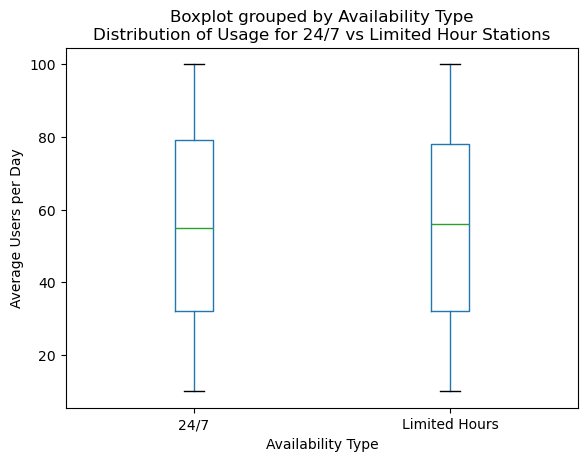

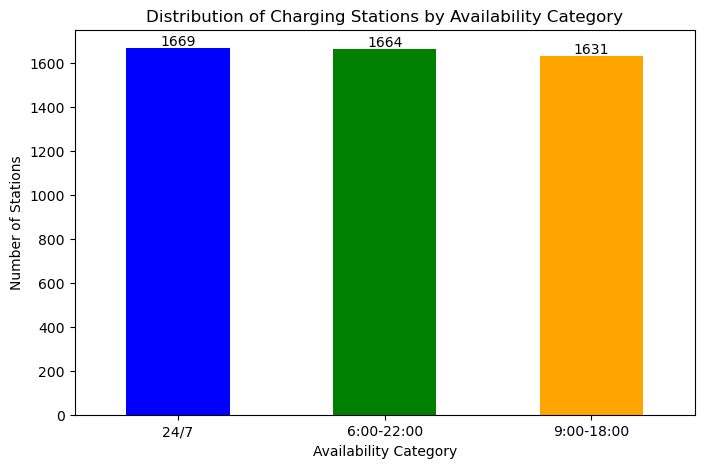

In [27]:
# 4.  Impact of 24/7 Availability on Usage
# Data Filtering, Statistical Comparison, and Box Plot Visualization to compare distribution
# ------------------------------------------------------------------------------------------

# Filter Data 
usage_availability = detailed_ev_charging_station[['Station ID', 'Latitude', 'Longitude', 'Address', 'Availability', 'Usage (avg users/day)']].copy()

# Compare Usage between 24/7 stations and limiited hour stations
# Calculate Average Daily Usage for both Categories 

usage_availability['Availability Type'] = usage_availability['Availability'].apply(lambda x: '24/7' if x == '24/7' else 'Limited Hours')
usage_comparison = usage_availability.groupby('Availability Type')['Usage (avg users/day)'].mean()

# Build 1-2 data visualization using Box Plot and or Bar Charts 
# Create a box plot showing all data points for 24/7 and limited availability
plt.figure(figsize=(8, 5))
usage_availability.boxplot(column='Usage (avg users/day)', by='Availability Type', grid=False, showfliers=True)

# Set plot labels and title
plt.xlabel("Availability Type")
plt.ylabel("Average Users per Day")
plt.title("Distribution of Usage for 24/7 vs Limited Hour Stations")

# Show the plot
plt.show()

#Define Binning
def usage_category_bins(time):
    if time == "24/7":
        return "24/7"
    elif time == "6:00-22:00":
        return "6:00-22:00"
    elif time == "9:00-18:00":
        return "9:00-18:00"
    else:
        return "Other"

#Apply Binning
usage_availability['Availability Categories'] = usage_availability['Availability'].apply(usage_category_bins)

#Count the number of stations in each bin
availability_categories = usage_availability['Availability Categories'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
ax = availability_categories.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

# Set labels and title
plt.xlabel("Availability Category")
plt.ylabel("Number of Stations")
plt.title("Distribution of Charging Stations by Availability Category")
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
# 5.  City-Wise Usage Analysis
# Group Data by City, Analyze Usage Patterns, and Visualize with Geoapify (placeholder for API integration)
# ---------------------------------------------------------------------------------------------------------

# Group Data by City

# Calculate average daily usage 

# Identify cities with highest and lowest utilization rates 

# Geoapify integration for mapping stations, map charging stations 

# Build 1-2 Data Visualizations for city usage, geospatial maps 

In [ ]:
# 6.  Cost Analysis by City
# Calculate Average Cost per kWh, Visualize with Pie Chart
# ----------------------------------------------------------

#Group Data by City 

# Calculate the average cost and distribution of costs.  

# Geoapify integration for creating mapping usage 

# Pie Chart for cost distribution 

# Build 1-2 Data Visualizations for cost differences across regions 